In [1]:

import h5py 

from PIL import Image
from matplotlib import pyplot as plt
import cv2
import random as r
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
from matplotlib import pyplot as plt
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Dense, Dropout, Activation, Concatenate, Flatten
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from zipfile import ZipFile
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [2]:
# Параметры аугментации
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Пути к папкам
train_nuclMask_folder = 'mekos_big_nucl/train/' 
test_nuclMask_folder = 'mekos_big_nucl/test'

train_cellMask_folder = 'mekos_big_full/train' 
test_cellMask_folder = 'mekos_big_full/test'




# Ширина и высота изображения
size = 200

# Размер батча
BS = 16 

# Подсчёт весовых коэффициентов для классов в силу их различной представленности
len_train_Blast = len(os.listdir( os.path.join( train_nuclMask_folder , 'B' ) ))
len_train_Lymph = len(os.listdir( os.path.join( train_nuclMask_folder , 'L' ) ))
len_train_Monoc = len(os.listdir( os.path.join( train_nuclMask_folder , 'M' ) ))

print('len b', len_train_Blast)
print('len l', len_train_Lymph)
print('len m', len_train_Monoc)

len_train = len_train_Blast + len_train_Lymph + len_train_Monoc

w_b = len_train/(3*len_train_Blast)
w_l = len_train/(3*len_train_Lymph)
w_m = len_train/(3*len_train_Monoc)

# Генераторы подаются на вход обучающей функции и формируют батчи "на лету"

# Генератор изображений с масками ядер
nuclMask_train_generator = train_datagen.flow_from_directory(
                    train_nuclMask_folder, 
                    target_size=(size, size),
                    batch_size=BS,
                    class_mode='sparse')

nuclMask_test_generator = test_datagen.flow_from_directory(
                    test_nuclMask_folder,
                    target_size=(size, size),
                    batch_size=BS,
                    class_mode='sparse')


# Генератор изображений с масками клеток
cellMask_train_generator = train_datagen.flow_from_directory(
                    train_cellMask_folder, 
                    target_size=(size, size),
                    batch_size=BS,
                    class_mode='sparse')

cellMask_test_generator = test_datagen.flow_from_directory(
                    test_cellMask_folder,
                    target_size=(size, size),
                    batch_size=BS,
                    class_mode='sparse')


len b 5308
len l 6168
len m 6183
Found 17659 images belonging to 3 classes.
Found 1957 images belonging to 3 classes.
Found 6019 images belonging to 3 classes.
Found 601 images belonging to 3 classes.


**Создание сети, состоящей из Inception-блоков: несколько различных слоёв получают одно и то же изображениие, затем результаты их преобразований конкатенируются. На картинке ниже представлен один из вариантов построения такого блока. В данной архитектуре использовался упрощённый, менее глубокий блок**
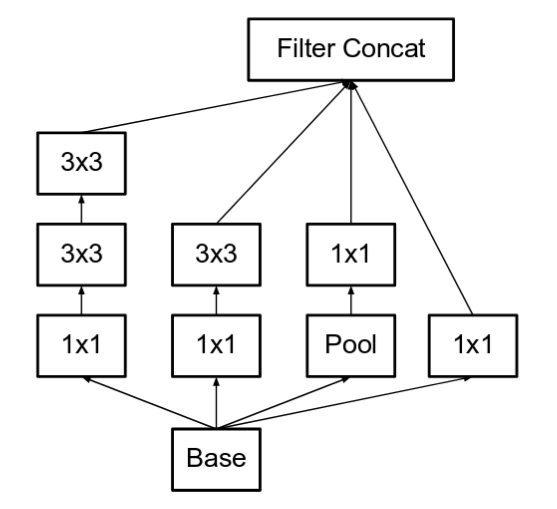

In [3]:
lyamb=0.001
l2_lambda = 0.001

inp = Input(shape=(size,size,3))

##
conv_1=Conv2D(32 , (3,3) , activation = 'relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb) )(inp)
pool_1=MaxPooling2D((2,2))(conv_1)
##

conv_2=Conv2D(64 , (3,3) , activation = 'relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb) )(pool_1)
pool_2=MaxPooling2D((2,2))(conv_2)
##
inc_1_a=Conv2D(128 , (1,1) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(pool_2)

inc_1_b=Conv2D(128 , (1,1) , activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(pool_2)

inc_1_b=Conv2D(128 , (3,3) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_b)



inc_1_c=Conv2D(128, (3,3), activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(pool_2) 

inc_1_c=MaxPooling2D( (2,2),strides=2 )(inc_1_c) 


inc_1_d=Conv2D(128 , (1,1) , activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(pool_2)

inc_1_d=Conv2D(128, (3,3) , activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_d)

inc_1_d=Conv2D(128, (3,3) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_d)

inc_1_out=Concatenate()([inc_1_a,inc_1_b,inc_1_c,inc_1_d])
##
inc_2_a=Conv2D(128 , (1,1) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_out)

inc_2_b=Conv2D(128 , (1,1) , activation='relu',
             kernel_initializer=initializers.he_uniform(),  padding='same',          
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_out)

inc_2_b=Conv2D(128 , (3,3) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_b)

inc_2_c=Conv2D(128, (3,3), activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_out) 

inc_2_c=MaxPooling2D( (2,2) , strides=2, padding='same')(inc_2_c) 

inc_2_d=Conv2D(128 , (1,1) , activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_1_out)

inc_2_d=Conv2D(128, (3,3) , activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_d)

inc_2_d=Conv2D(128, (3,3) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_d)

inc_2_out=Concatenate()([inc_2_a,inc_2_b,inc_2_c,inc_2_d])




##
inc_3_a=Conv2D(128 , (1,1) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_out)

inc_3_b=Conv2D(128 , (1,1) , activation='relu',
             kernel_initializer=initializers.he_uniform(), padding='same',           
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_out)

inc_3_b=Conv2D(128 , (3,3) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_3_b)

inc_3_c=Conv2D(128, (3,3), activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),          
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_out) 

inc_3_c=MaxPooling2D( (2,2) , strides=2, padding='same')(inc_3_c) 


inc_3_d=Conv2D(128 , (1,1) , activation='relu',
             kernel_initializer=initializers.he_uniform(),  padding='same',          
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_2_out)

inc_3_d=Conv2D(128, (3,3) , activation='relu',padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_3_d)

inc_3_d=Conv2D(128, (3,3) , activation='relu', strides=2,padding='same',
             kernel_initializer=initializers.he_uniform(),            
             kernel_regularizer=regularizers.l2(lyamb),
             bias_regularizer=regularizers.l2(lyamb))(inc_3_d)


inc_3_out=Concatenate()([inc_3_a,inc_3_b,inc_3_c,inc_3_d])

##


flat = Flatten()(inc_3_out)

dense_1=Dense(512, activation='relu', 
                         kernel_initializer=initializers.he_uniform(),
                         kernel_regularizer=regularizers.l2(l2_lambda))(flat)

dense_2=Dense(128, activation='relu', 
                         kernel_initializer=initializers.he_uniform(),
                         kernel_regularizer=regularizers.l2(l2_lambda))(dense_1)

out=Dense(3, activation='softmax',
                         kernel_initializer=initializers.glorot_uniform(),
                         kernel_regularizer=regularizers.l2(l2_lambda))(dense_2)
  


  

modelInception = Model(inputs=inp , outputs = out)


**Конфигурация обучения для сети с Inception-блоками**

In [42]:
#CB=[
#   ModelCheckpoint(filepath='Inception_model.h5',monitor='val_accuracy',save_best_only=True)]

# Здесь использован оптимизатор  RMSprop

#rms=optimizers.RMSprop(lr=0.0001, rho=0.99, epsilon=None, decay=0.0)
 
#modelInception.compile(loss='sparse_categorical_crossentropy',
#              optimizer='adam',metrics=['acc'])

#w_b = 2.6
#w_l = 0.5
#w_m = 2.1
#with tf.device(tf.DeviceSpec(device_type="GPU", device_index=0)):
    
#    InceptionHistory = modelInception.fit_generator(

#       cellMask_train_generator,
#       steps_per_epoch=100,
#       epochs=65,

#        class_weight={ 0:w_b, 1:w_l, 2:w_m },
#        callbacks=CB,
#          validation_data=cellMask_test_generator
#       )



In [28]:
modelInception = tf.keras.models.load_model('InceptionModel.h5')

In [6]:
cell_test_gen = test_datagen.flow_from_directory(
                    test_cellMask_folder,
                    target_size=(size, size),
                    batch_size=500,
                    class_mode='sparse')


Found 601 images belonging to 3 classes.


In [7]:
pred = modelInception.predict(cell_test_gen[0][0])


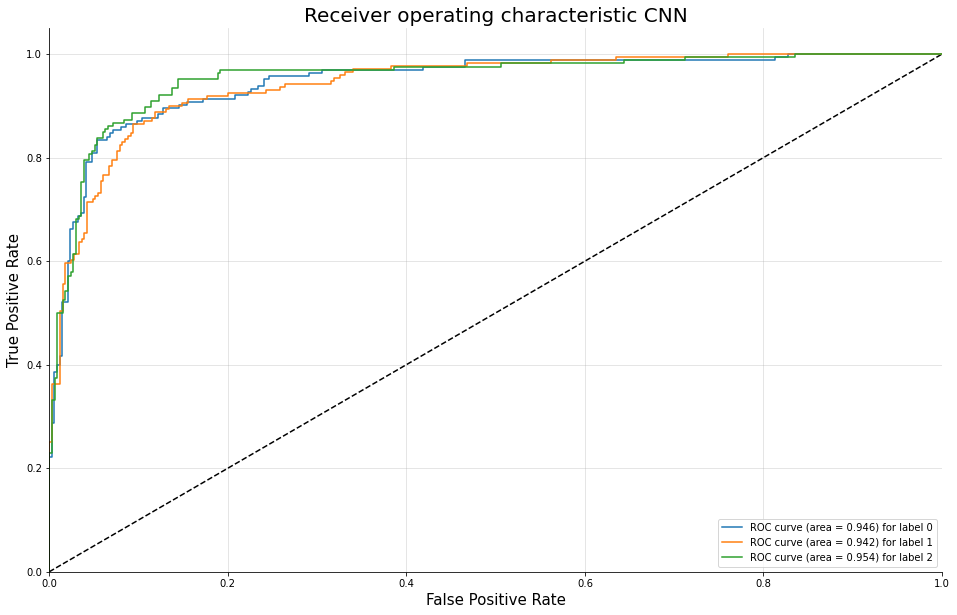

In [40]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import seaborn as sns


def plot_multiclass_roc(y_score, y_test, n_classes, figsize=(17, 6), savepath=None ):
    
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=15)
    ax.set_ylabel('True Positive Rate', fontsize=15)
    ax.set_title('Receiver operating characteristic CNN', fontsize=20)
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.3f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    
    if savepath is not None:
        plt.savefig(savepath, dpi=300)
    
    plt.show()


plot_multiclass_roc(pred, cell_test_gen[0][1], n_classes=3, figsize=(16, 10), savepath='InceptionROC.png')

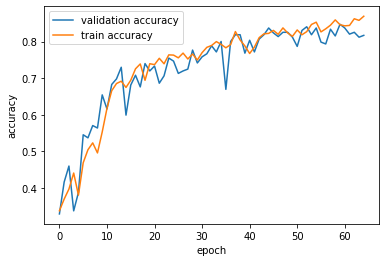

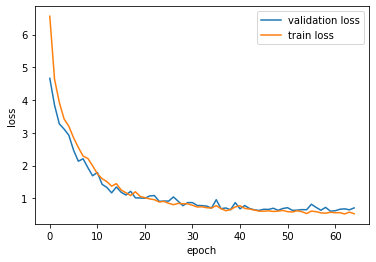

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,5))


axs[0].plot(InceptionHistory.history['val_acc'], label='validation accuracy')
axs[0].plot(InceptionHistory.history['acc'], label='train accuracy')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('accuracy')
axs[0].set_title('Model accuracy')
axs[0].legend()

axs[1].plot(InceptionHistory.history['val_loss'], label='validation loss')
axs[1].plot(InceptionHistory.history['loss'], label='train loss')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[0].set_title('Model accuracy')
axs[1].legend()
plt.show()


In [12]:
def func_to_labels(func):
    
    
    predicted = []
    
    for i in func:
        predicted.append(np.argmax(i))
    return predicted
    

In [13]:
from sklearn.metrics import classification_report

predicted_labels = func_to_labels(pred)
real_labels = cell_test_gen[0][1]

print(np.array([real_labels, predicted_labels]).T[:30])
print(classification_report(real_labels, predicted_labels))

[[0. 0.]
 [2. 2.]
 [1. 0.]
 [1. 2.]
 [2. 2.]
 [0. 0.]
 [1. 1.]
 [2. 2.]
 [0. 0.]
 [0. 0.]
 [0. 2.]
 [2. 2.]
 [2. 2.]
 [2. 2.]
 [1. 0.]
 [0. 0.]
 [1. 1.]
 [2. 2.]
 [1. 2.]
 [2. 2.]
 [0. 0.]
 [1. 0.]
 [1. 1.]
 [0. 0.]
 [2. 2.]
 [1. 2.]
 [2. 2.]
 [0. 0.]
 [0. 0.]
 [1. 2.]]
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82       163
         1.0       0.95      0.56      0.71       171
         2.0       0.77      0.95      0.85       166

    accuracy                           0.80       500
   macro avg       0.82      0.80      0.79       500
weighted avg       0.82      0.80      0.79       500



In [16]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(real_labels, predicted_labels)
print(cm)

[[146   5  12]
 [ 39  96  36]
 [  9   0 157]]


In [34]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True ,
                          savepath=None
                         ):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    
    
    
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=15)
    
    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath, dpi=300)
    
    plt.show()

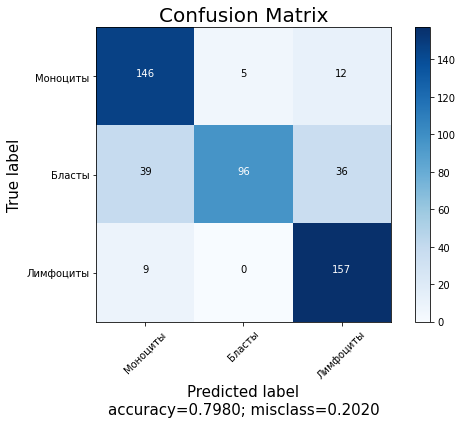

In [35]:
plot_confusion_matrix(cm           = np.array(cm), 
                      normalize    = False,
                      target_names = ['Моноциты', 'Бласты', 'Лимфоциты'],
                      title        = "Confusion Matrix",
                      savepath='CNN_cm.png'
                     )

In [36]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)

Normalized confusion matrix
[[0.89570552 0.03067485 0.07361963]
 [0.22807018 0.56140351 0.21052632]
 [0.05421687 0.         0.94578313]]


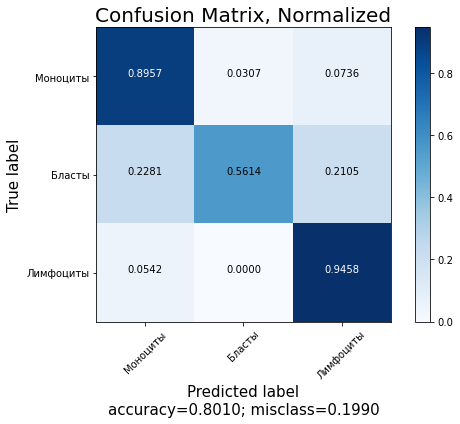

In [37]:
plot_confusion_matrix(cm           = np.array(cm_normalized), 
                      normalize    = True,
                      target_names = ['Моноциты', 'Бласты', 'Лимфоциты'],
                      title        = "Confusion Matrix, Normalized",
                      savepath='CNN_cm_norm.png'
                     )

In [38]:
tf.keras.utils.plot_model(
    modelInception, 
    to_file="InceptionModel.png",
    show_shapes=True,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [22]:
modelInception.save('InceptionModel.h5')